# MAE 598: Design Optimization - Homework 3

## Problem 1

Equilibrium pressure is given by

equilibrium relation can be formulated as:

$$ {p = x_1 \exp\Bigg(A_{12} \ \Big(\frac{A_{21} \ x_2}{A_{12} \ x_1 \ + \ A_{21} \ x_2}\Big)^2\Bigg) \ p^{sat}_{1} \ + \
        x_2 \exp\Bigg(A_{21} \ \Big(\frac{A_{12} \ x_1}{A_{12} \ x_1 \ + \ A_{21} \ x_2}\Big)^2\Bigg) \ p^{sat}_{2}} $$
        
        
Saturation pressure is given by

$$ {\log_{10}(p^{sat}) = a_1 - \frac{a_2}{T + a_3}} $$

$ p^{sat} $ is calculated by rearranging the above expression

$$ { p^{sat} = 10^{\displaystyle\Big(a_1 - \frac{a_2}{T + a_3}\Big)}} $$


Relation between $ x_1 $ and $ x_2 $ is given by

$$ {x_1 + x_2 = 1 } $$

$ x_2 $ caluculated from this expression and the given values of $ x_1 $


The objective function


$$ {\min_{A_{12}, A_{21}} \quad  \displaystyle \sum_{i=1}^{n=11}(p(x_i, A) - p_m)^2 } $$

where,

$ p(x_i, A) $ is the output from the prediction model

$ p_m $ is the measured value

The objective function is modeled using **MSELoss()** method from **torch.nn** module and the gradient descent is performed using **torch.optim.SGD()** (Stochastic Gradient Descent) optimizer in PyTorch.

In [26]:
# Import libraries
import torch as t
import numpy as np
import torch.nn as nn
from matplotlib import pyplot as plt

In [27]:
# Initialize all given data

T = 20.0 # Temperature in °C

# x1 and x2 values
x1 = t.linspace(0., 1.0, 11, dtype=t.float32)
x2 = 1 - x1

# Measured pressure values
pm = t.tensor([28.1, 34.4, 36.7, 36.9, 36.8, 36.7, 36.5, 35.4, 32.9, 27.7, 17.5], dtype=t.float32)

# Constants a1, a2 and a3
a = t.tensor([[8.07131, 1730.63, 233.426], 
              [7.43155, 1554.679, 240.337]], dtype=t.float32)

In [28]:
# Calculate the saturation pressure
pSat =  lambda a: 10.0 ** (a[0] - (a[1] / (T + a[2])))

pSat1 = pSat(a[0,:]) # Water
pSat2 = pSat(a[1,:]) # 1,4 dioxane
print(f'Saturation pressures \nWater: {pSat1} \n1,4 dioxane: {pSat2} \n')

Saturation pressures 
Water: 17.473241806030273 
1,4 dioxane: 28.82411003112793 



In [29]:
# Define the pressure equilibrium relation
def forward():
    p = lambda A: (x1 * pSat1 * t.exp(A[0] * ((A[1] * x2) / (A[0] * x1 + A[1] * x2)) ** 2)) + (x2 * pSat2 * t.exp(A[1] * ((A[0] * x1) / (A[0] * x1 + A[1] * x2)) ** 2))
    return p(A)

In [30]:
# Define initial parameters
learnig_rate = 0.001
max_iters = 200
A = t.tensor([0.1, 0.1], requires_grad=True) # Optimization variable A12 = A[0], A21 = [1]

# Define MSE loss function
loss = nn.MSELoss(reduction='sum')
# Select Stochastic Gradient Descent as the optimization method
optimizer = t.optim.SGD([A], lr=learnig_rate)

# Train the model
for epochs in range(max_iters):
    p_pred = forward() # Forward pass to calculate the predicted pressure value
    cost = loss(pm, p_pred) # Compute the loss
    
    # Output the training parameters
    if epochs % 10 == 9:
        print(f'epoch; {epochs} \t Loss: {cost} \t A: {A}')

    cost.backward() # Compute the gradient
    optimizer.step() # Compute the next step, update A
    optimizer.zero_grad() # Clear out the current gradient

epoch; 9 	 Loss: 0.9369445443153381 	 A: tensor([1.9045, 1.7355], requires_grad=True)
epoch; 19 	 Loss: 0.6986766457557678 	 A: tensor([1.9405, 1.7041], requires_grad=True)
epoch; 29 	 Loss: 0.6733143925666809 	 A: tensor([1.9525, 1.6941], requires_grad=True)
epoch; 39 	 Loss: 0.6705505847930908 	 A: tensor([1.9564, 1.6908], requires_grad=True)
epoch; 49 	 Loss: 0.6702479124069214 	 A: tensor([1.9578, 1.6897], requires_grad=True)
epoch; 59 	 Loss: 0.6702129244804382 	 A: tensor([1.9582, 1.6894], requires_grad=True)
epoch; 69 	 Loss: 0.6702102422714233 	 A: tensor([1.9583, 1.6892], requires_grad=True)
epoch; 79 	 Loss: 0.6702093482017517 	 A: tensor([1.9584, 1.6892], requires_grad=True)
epoch; 89 	 Loss: 0.6702074408531189 	 A: tensor([1.9584, 1.6892], requires_grad=True)
epoch; 99 	 Loss: 0.6702079176902771 	 A: tensor([1.9584, 1.6892], requires_grad=True)
epoch; 109 	 Loss: 0.6702081561088562 	 A: tensor([1.9584, 1.6892], requires_grad=True)
epoch; 119 	 Loss: 0.6702081561088562 	 A: 

In [31]:
# Output results
print("Predicted pressure values:\n", p_pred.detach().numpy())
print(f"\nOptimized values of A \nA12: {A[0].item()} \t A21: {A[1].item()}")

Predicted pressure values:
 [28.82411  34.644318 36.452972 36.867317 36.874012 36.749836 36.39045
 35.38482  32.94778  27.729994 17.473242]

Optimized values of A 
A12: 1.958418369293213 	 A21: 1.6891862154006958


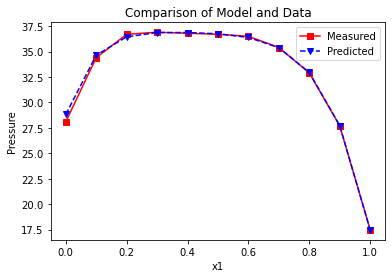

In [32]:
# Plot results
plt.plot(x1, pm, 'rs-', label="Measured")
plt.plot(x1, p_pred.detach().numpy(), 'bv--', label="Predicted")
plt.xlabel('x1')
plt.ylabel('Pressure')
plt.title('Comparison of Model and Data')
plt.legend()
plt.show()

## Problem 2

Objective function


$$ {\min_{x_{1}, x_{2}} \quad  \Big(4 - 2.1 x^2_1 + \frac{x^4_1}{3}\Big) \ x^2_1 + x_1 x_2 + (-4 + 4 x^2_2) \ x^2_2 } $$

$$ {for \quad x_1 \in [-3, 3] \quad and \quad x_2 \in [-2, 2]} $$

In [33]:
# Import libraries
import numpy as np
import sklearn
from matplotlib import pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from scipy.optimize import minimize
import sklearn.gaussian_process as gp

In [34]:
# Define the function
def objFunc(x):
    f = lambda x: (4 - 2.1 * (x[0] ** 2) + ((x[0] ** 4) / 3)) * (x[0] ** 2) + x[0] * x[1] + (-4 + 4 * (x[1] ** 2))  * (x[1] ** 2)
    # f = lambda x: (4 - 2.1 * (x[:, 0] ** 2) + ((x[:, 0] ** 4) / 3)) * (x[:, 0] ** 2) + x[:, 0] * x[:, 1] + (-4 + 4 * (x[:, 1] ** 2))
    # return f(x).tolist()
    return f(x)


In [49]:
bounds = np.array([[-3, 3], [-2, 2]])



x1, x2 = np.mgrid[-3:3:100j, -2:2:100j]
X1 = np.reshape(x1, -1).reshape(-1, 1)
X2 = np.reshape(x2, -1).reshape(-1, 1)
X = np.hstack((X1, X2))

# No noise
f = objFunc(X.T)



# # Starting point
# np.random.seed(99)
X0 = np.random.uniform(bounds[:, 0], bounds[:, 1], (5, bounds.shape[0]))
m, n = X0.shape
f0 = objFunc(X0.T)

Xs = X0
ys = f0

print(X0)
print(f0.shape)
type(f0)

[[ 2.41196596 -1.24272132]
 [ 0.33342299 -0.1568926 ]
 [ 1.14480052  1.74032843]
 [ 1.89111307 -1.40662266]
 [-0.02759998 -1.30366367]]
(5,)


numpy.ndarray

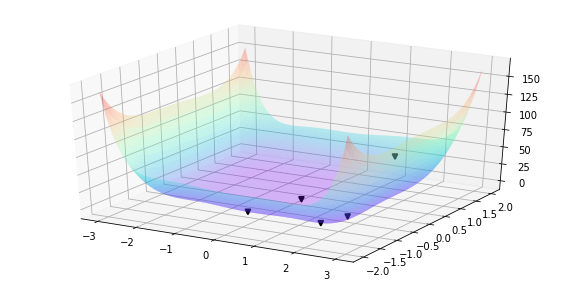

In [50]:
fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(111, projection='3d')
# ax1.plot_wireframe(x1, x2, f, alpha=0.3)

ax1.plot_trisurf(X[:, 0], X[:, 1], f.ravel(), alpha=0.3, cmap="rainbow", label="Actual function")
ax1.scatter(X0[:, 0], X0[:, 1], f0, alpha=1, marker="v", color="black", label="Initial point", linewidth=2)
plt.show()

In [37]:
def EI(X, model, ys, n_params):

    X = X.reshape(-1, n_params)

    mu, sigma = model.predict(X, return_std=True)

    loss_optimum = np.min(ys)

    scaling_factor = -1

    # In case sigma equals zero
    with np.errstate(divide='ignore'):
        Z = scaling_factor * (mu - loss_optimum) / sigma
        ei = scaling_factor * (mu - loss_optimum) * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] == 0.0

    return -1 * ei

In [38]:
def next_sample(acquisition, model, ys, bounds, n_restarts=25):
    best_x = None
    best_acquisition_value = 1
    n_params = bounds.shape[0]

    for starting_point in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, n_params)):

        res = minimize(fun=acquisition,
                       x0=starting_point.T,
                       bounds=bounds,
                       method='L-BFGS-B',
                       args=(model, ys, n_params))

        if res.fun < best_acquisition_value:
            best_acquisition_value = res.fun
            best_x = res.x

    return best_x

In [52]:
n_iters = 10
n_pre_samples=50
alpha=1e-5
epsilon=1e-7

x_list = []
y_list = []

n_params = bounds.shape[0]

for params in np.random.uniform(bounds[:, 0], bounds[:, 1], (n_pre_samples, bounds.shape[0])):
    x_list.append(params)
    print(params)
    y_list.append(objFunc(params))



xp = np.array(x_list)
yp = np.array(y_list)


kernel = gp.kernels.Matern()
model = gp.GaussianProcessRegressor(kernel=kernel,
                                    alpha=alpha,
                                    n_restarts_optimizer=10,
                                    normalize_y=True)

for n in range(n_iters):

    model.fit(xp, yp)


    sample = next_sample(EI, model, yp, bounds=bounds, n_restarts=100)

    # Duplicates will break the GP. In case of a duplicate, we will randomly sample a next query point.
    if np.any(np.abs(sample - xp) <= epsilon):
        sample = np.random.uniform(bounds[:, 0], bounds[:, 1], bounds.shape[0])

    # Sample loss for new set of parameters
    cv_score = objFunc(sample)

    # Update lists
    x_list.append(sample)
    y_list.append(cv_score)

    # Update xp and yp
    xp = np.array(x_list)
    yp = np.array(y_list)

[-0.80599217  1.06978193]
[-2.1743504  -1.89000828]
[0.12202195 1.67322806]
[-2.57448655 -0.29306614]
[-0.91044858  0.76104904]
[0.46501283 0.3340636 ]
[ 2.01940482 -0.95597066]
[1.5200703 1.9455283]
[ 1.45732363 -0.62758653]
[-0.71152211  1.13100571]
[-0.29636439  0.75800388]
[0.0094856  0.07460606]
[ 1.20246271 -1.3032216 ]
[-2.88973799 -1.44777014]
[2.48418056 0.43038629]
[0.41414497 0.16986268]
[-2.34730364 -1.71623601]
[ 1.73705457 -1.46612272]
[ 1.90542301 -1.88560465]
[ 2.59811972 -1.82845023]
[1.30574063 0.21321732]
[-1.66851021 -1.68189563]
[ 1.61611887 -0.58067552]
[-0.83123511  1.77971722]
[ 1.2380315  -1.51055741]
[ 2.34503463 -0.56597498]
[ 2.08987382 -1.03644237]
[-0.05315928  0.49198865]
[ 2.49026989 -0.94228753]
[-2.89651859 -0.38048249]
[1.32845927 0.37815305]
[2.36503447 0.08334568]
[-2.8880625  -0.81784482]
[-2.7685121   1.81177703]
[0.4087313  0.21367707]
[2.56926058 0.23567528]
[0.94305073 0.16790005]
[2.03864614 1.45882699]
[-0.6869744   0.78298659]
[1.90041016 1.

In [53]:
print('\nMinimum function value:', np.min(yp))
print('\n Optimal X values:',xp[np.argmin(yp)])
print('\nAll sampled X values:', xp)
print('\nAll sampled function values:', yp)


Minimum function value: -0.8670497332999467

 Optimal X values: [-0.29636439  0.75800388]

All sampled X values: [[-0.80599217  1.06978193]
 [-2.1743504  -1.89000828]
 [ 0.12202195  1.67322806]
 [-2.57448655 -0.29306614]
 [-0.91044858  0.76104904]
 [ 0.46501283  0.3340636 ]
 [ 2.01940482 -0.95597066]
 [ 1.5200703   1.9455283 ]
 [ 1.45732363 -0.62758653]
 [-0.71152211  1.13100571]
 [-0.29636439  0.75800388]
 [ 0.0094856   0.07460606]
 [ 1.20246271 -1.3032216 ]
 [-2.88973799 -1.44777014]
 [ 2.48418056  0.43038629]
 [ 0.41414497  0.16986268]
 [-2.34730364 -1.71623601]
 [ 1.73705457 -1.46612272]
 [ 1.90542301 -1.88560465]
 [ 2.59811972 -1.82845023]
 [ 1.30574063  0.21321732]
 [-1.66851021 -1.68189563]
 [ 1.61611887 -0.58067552]
 [-0.83123511  1.77971722]
 [ 1.2380315  -1.51055741]
 [ 2.34503463 -0.56597498]
 [ 2.08987382 -1.03644237]
 [-0.05315928  0.49198865]
 [ 2.49026989 -0.94228753]
 [-2.89651859 -0.38048249]
 [ 1.32845927  0.37815305]
 [ 2.36503447  0.08334568]
 [-2.8880625  -0.81784

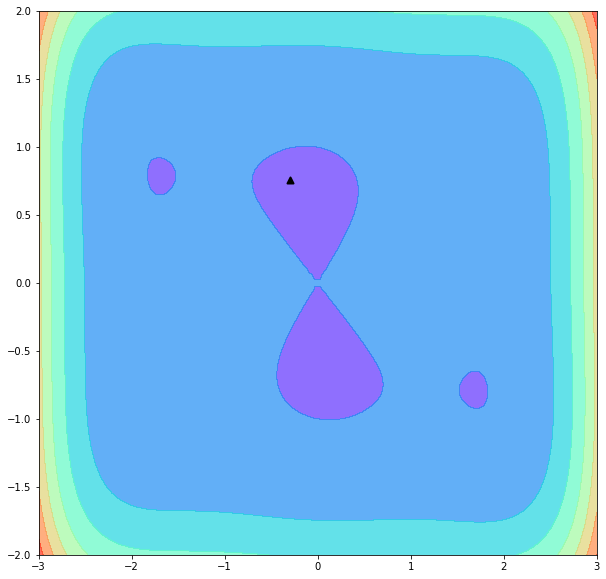

array([-0.29636439,  0.75800388])

In [78]:
fig2 = plt.figure(figsize=(10,10))
ax2 = fig2.add_subplot(111)


ax2.contourf(x1, x2, objFunc([x1, x2]), alpha=0.7, cmap="rainbow")
ax2.scatter(xp[np.argmin(yp)][0], xp[np.argmin(yp)][1], alpha=1, marker="^", color="black", label="Minima", linewidth=2)
plt.show()

xp[np.argmin(yp)]
# np.min(yp)